In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.datasets import load_iris

In [2]:
iris = load_iris()
iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
def get_columns(data):
    print("--- debut get_columns ---")
    cols = data.columns.tolist()
    print(cols)
    print("--- fin get_columns ---")
    return cols

In [4]:
def select_target_column(data,target_column):
    print("--- debut select_target_column ---")
    if target_column not in data.columns:
        raise ValueError(f"Colonne cible '{target_column}' non trouvée dans le dataset.")
    else : 
        X = data.drop(columns=[target_column])
        y = data[target_column]

        # Détecter si le problème est une classification
        is_classification = y.nunique() <= 10

        # Encoder les classes si nécessaire
        if is_classification and y.dtype == 'object':
            y = y.astype('category').cat.codes
        print("--- fin select_target_column ---")
        return X, y, is_classification

In [5]:
def split_data(X, y):
    print("--- debut split_data ---")
    print("--- fin split_data ---")
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
def train_xgboost(X_train, y_train, X_test, y_test, is_classification):
    print('--- debut train_xgboost ---')
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "multi:softprob" if is_classification else "reg:squarederror",
        "eval_metric": "mlogloss" if is_classification else "rmse",
        "num_class": len(set(y_train)) if is_classification else None,
        "max_depth": 6,
        "learning_rate": 0.1,
        "n_estimators": 100,
    }

    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, "train"), (dtest, "test")],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=10
    )
    print('--- fin train_xgboost ---')
    return model, evals_result, dtest

In [7]:
def evaluate_model(model, dtest, y_test, is_classification):
    print("--- debut evaluate_model ---")
    """Évalue le modèle et retourne les métriques."""
    y_pred = model.predict(dtest)
    if is_classification:
        y_pred_classes = y_pred.argmax(axis=1)
        accuracy = accuracy_score(y_test, y_pred_classes)
        print(f"Accuracy: {accuracy:.2f}")
    else:
        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error: {mse:.2f}")
    print("--- fin evaluate_model")

In [8]:
def plot_learning_curves(evals_result):
    print("--- debut plot_learning_curves ---")
    """Trace les courbes d'apprentissage."""
    plt.figure(figsize=(10, 6))
    for metric in evals_result["train"]:
        plt.plot(evals_result["train"][metric], label=f"Train {metric}")
        plt.plot(evals_result["test"][metric], label=f"Test {metric}")
    plt.xlabel("Rounds")
    plt.ylabel("Metric Value")
    plt.title("XGBoost Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("--- fin plot_learning_curves ---")

In [9]:
def plot_feature_importance(model):
    print("--- debut plot_feature_importance---")
    """Trace l'importance des caractéristiques."""
    xgb.plot_importance(model, importance_type="weight", max_num_features=10)
    plt.title("Feature Importance")
    plt.show()
    print("--- fin plot_feature_importance")

--- debut get_columns ---
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
--- fin get_columns ---
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
--- debut select_target_column ---
--- fin select_target_column ---
--- debut split_data ---
--- fin split_data ---
--- debut train_xgboost ---
[0]	train-rmse:0.68031	test-rmse:0.73184
[10]	train-rmse:0.28018	test-rmse:0.35339
[20]	train-rmse:0.14134	test-rmse:0.23967
[30]	train-rmse:0.08684	test-rmse:0.21414
[40]	train-rmse:0.06514	test-rmse:0.20570
[50]	train-rmse:0.05094	test-rmse:0.20655
--- fin train_xgboost ---
--- debut evaluate_model ---
Mean Squared Error: 0.04
--- fin evaluate_model
--- debut plot_learning_curves ---


/Users/gabinsordel/Desktop/DevWeb/templateFlaskVue/ProDAI/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


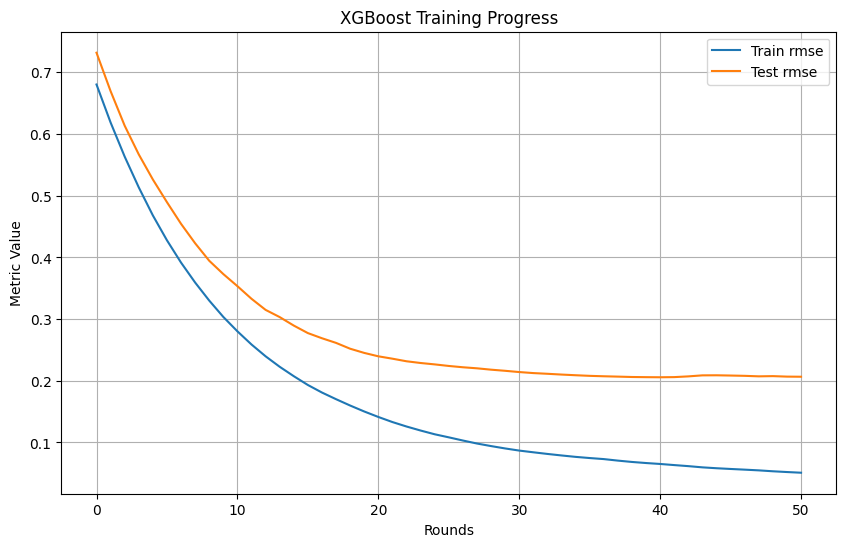

--- fin plot_learning_curves ---
--- debut plot_feature_importance---


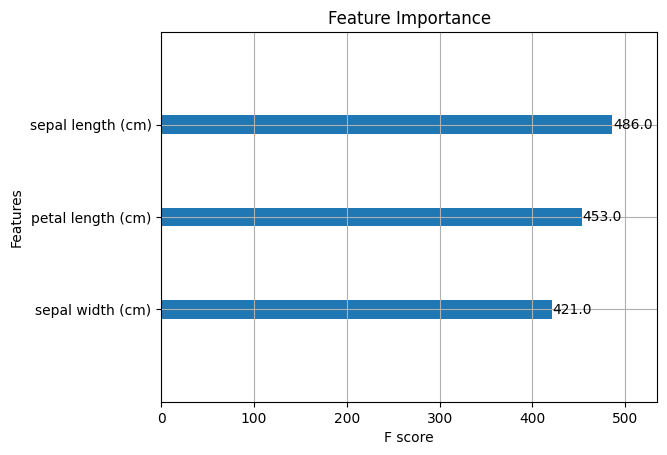

--- fin plot_feature_importance


In [11]:
def main(data):
    cols = get_columns(data)
    print(cols)
    col = cols[3]
    x_y = select_target_column(data,col)
    train_split = split_data(x_y[0],x_y[1])
    results = train_xgboost(train_split[0],train_split[2],train_split[1],train_split[3],x_y[2])
    evaluation = evaluate_model(results[0],results[2],train_split[3],x_y[2])
    plot_learning_curves(results[1])
    plot_feature_importance(results[0])
main(iris)